<a href="https://colab.research.google.com/github/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/crispr_counts_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# High-content CRISPR screens: how to survey the genome

## Table of contents
1. [Introduction and aims](#intro)
2. [Today's exercise](#exercise)
3. [Step 1: Installing software and importing data for our session](#step1)
3. [Step 2: Exploring a "raw" counts dataset](#step2)
4. [Step 3: Identifying significantly perturbed genes in the screen](#step3)
5. [Step 4: Validating the results a CRISPR screen](#step4)
6. [Step 5: Alternative analysis tools and considerations](#step5)
7. [Summary](#summary)
8. [References](#references)

-----
## <a name="intro"></a>
## Introduction and aims

The aim of this practical class is to introduce you to some of the concepts and tools involved in the analysis of pooled CRISPR screens. Will we begin by taking set of pre-generated CRISPR counts data and exploring it in R. Then, we will process the dataset to identify essential genes in a cell line using a popular tool called MAGECK. Finally, we will explore some alternative tools for CRIPSR screen analyis and discuss some of pitfalls that you might need to be wary of in these kinds of experiment.

----

## Background

Throughout this course we have seen how CRISPR systems can applied as powerful tools for cellular manipulation. Depending on how they are configured, CRISPR systems can be used to:

- Introduce double standed breaks at a genomic locus
- Introduce sequence modifications to a locus
- Recruit funcitonal domains to that locus
- Modulate gene expression (activiation with CRISPRa and inhibition with CRISPRi)


CRIPSR screens attempt to perform these manipulations at scale: interrogating thousands of genomic features (genes, promoters, enhancers *etc.*) simultaneously. Pooled screens enable us to achieve this within a single population of cells.

----
### The CRISPR screening process

The process of conducting a pooled CRISPR screen is illustrated below in Figure 1. Essentially, we aim to deliver a "library" of guide RNAs into population of cells experessing Cas9 and observe the effects. It can be broken down into the following steps:

🧬 **Design** 🧬

First, we prepare a library of guide RNAs that target your sequences of interest. You might be able to order an off-the-shelf pre-deisgned library for this (popular libraries include Yusa, GeCkO and TKO); you might have to design a library of your own. Whilst we won't cover the custom gRNA library design process in detail here, I'd personally recommend looking at the [CRISPRverse](https://github.com/crisprVerse/Tutorials/tree/master) collection of R packages. They have several helpful tutorials that walk you through library design.

📦 **Delivery** 📦

You will now need to deliver your guide library into your cells of interest. A popular means for doing this is to package your library into lentiviral vectors and then transduce your cells. If you aim for a low mutliplicity of infection (MOI) you should be able to effectively introduce a single guide RNA into each cell in the population.

 🥼 **Cell Culture and Phenotypic Selection** 🥼

You can now subject your diversified cell population to some sort of selective pressure. This might be just be survival in the presence of CRISPR-Cas9, survival in the presence of a drug, or the expression of a fluorescent reporter (measured with a flow cytometer). Typically you would culture cells for multiple passages under selection to allow time for CRISPR-mediated genetic modifications and to amplify phenotypic effects.


💻 **Genomic DNA Extraction and Sequencing** 💻

Finally, you will need to amplfy gRNA DNA from both selected and control cell populations using PCR. If you perform high-throughput sequencing to quantify gRNA abundance you can then compare guide RNA counts in a selected and control population of cells. This should reveal which guides (and by proxy which target sequences) are associated with the phenotype.

----

### Figure 1. Process diagram for a CRISPR screen

![Figure 1. Process diagram for a CRISPR screen](https://github.com/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/figures/CRISPR_screen_demo.jpg?raw=1)

Taken from [Clark, Teleri et al.
Trends in Biotechnology, Volume 42, Issue 8, 1017 - 1034](https://www.cell.com/trends/biotechnology/fulltext/S0167-7799(24)00036-2)

-----

 Screens can be classified as:

- **Knockout screens**: Identify essential genes or genes involved in specific phenotypes
- **Activation screens**: Uncover genes that, when overexpressed, contribute to a phenotype
- **Inhibition screens**: Reveal genes that, when repressed, affect a particular cellular process

At the Wellcome Trust Sanger Institute, we conduct large scale CRISPR knockout screens of cancer cell lines for initiatives such as [DepMap](https://depmap.sanger.ac.uk/documentation/datasets/wg-crispr-knockout/) to better understand the genetic dependencies of cancer.

### Figure 2. The Project Score portal

![Figure 2. Project score ](https://github.com/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/figures/project_score.png?raw=1)

----


## <a name="exercise"></a>
### Today's exercise

Today, we will explore the results of a simple CRISPR knockout screen designed to identify essential genes in the HAP1 cell line. HAP1 is a human myeloid leukemia cell line derivative that is notable for containing 1 copy of each gene: it is near haploid ([Andersson et al., 1987](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10020200/#B2)). HAP1 has become a popular particularly within the field of gene editing it avoids some of the the challenges associated with interpreting experiments in diploid cells such as mixed penetrance of genome editing.


### Figure 3. Karotype of the HAP1 cell line

![Figure 3. HAP1 karotype](https://github.com/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/figures/HAP1_cell_karyotype.png?raw=1)

https://commons.wikimedia.org/wiki/File:HAP1_cell_karotype.png




**Experimental Design**

The screen we will examine today is a straightforward experiment involving just four samples:

- T0 Sample: A single "pre-screen" cell population sample. Collected before CRISPR-Cas9 cutting occurred (*serves as a baseline for guide RNA distribution measurements*).


- T18 Samples: Three post-screen samples (A, B, and C). Collected 18 days after the screen began (*represents the cell populations after CRISPR-mediated gene knockout and selection*).

To conduct the experiment, HAP1 cells were transfected with the [TKO_V3 library](https://www.addgene.org/pooled-library/moffat-crispr-knockout-tkov3/) which contains more than 70,000 guides targeting >18,000 genes.

**Data Analysis Approach**

We will:
- Evaluate the quality of HTS derived samples based on gRNA count statistics ✅
- Compare guide frequencies between T0 and T18 samples ✅
- Use statistical methods to identify significantly depleted or enriched guides ✅
- Map guides to their target genes to identify essential genes in HAP1 ✅

----

## <a name="step1"></a>
## Step 1: Installing software and importing data for our session

In order to install some of the tools we will be using in the session, we will first have to add condacolab. Condacolab allows us install software packages within the code cells of our google colab session with the `conda install` command.



In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


Next, we can download the datasets that we're going to use in the exercise. These are: a counts matrix, containing the results of our screen and two gene lists describing essential and non-essentail genes that will use later in the practical.

We download the data using the `wget` command, which can grab any files at a certain web addresss



In [2]:
!wget https://raw.githubusercontent.com/WCSCourses/CRISPR_Informatics_2024/jb63_screening_module/course_data/reads_hap1.txt
!wget https://raw.githubusercontent.com/WCSCourses/CRISPR_Informatics_2024/jb63_screening_module/course_data/CEGv2.txt
!wget https://raw.githubusercontent.com/WCSCourses/CRISPR_Informatics_2024/jb63_screening_module/course_data/NEGv1.txt

--2024-09-17 09:35:18--  https://raw.githubusercontent.com/WCSCourses/CRISPR_Informatics_2024/jb63_screening_module/course_data/reads_hap1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3649737 (3.5M) [text/plain]
Saving to: ‘reads_hap1.txt’

reads_hap1.txt      100%[===================>]   3.48M  --.-KB/s    in 0.08s   

2024-09-17 09:35:18 (43.5 MB/s) - ‘reads_hap1.txt’ saved [3649737/3649737]

--2024-09-17 09:35:18--  https://raw.githubusercontent.com/WCSCourses/CRISPR_Informatics_2024/jb63_screening_module/course_data/CEGv2.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.


Next, we will load an extension for the collab notebook that lets us execute R code within collab notebook cells.

In [2]:
%load_ext rpy2.ipython

Now, any cells that contain the `%%R` tag at the start will be executed within an R environment.

*Note: any lines of code that contain an `!` at the start will be executed in bash (the default scripting language in a terminal).*

We will the exercise by loading a couple of R packages into our collab session. For those newer to R, this notebook loads the `tidyverse` meta package: a set of tools that extend "base" R to make data-wrangling and exploration more enjoyable. The code also makes use of the `|>` pipe functionality in R, which simplifies multi-step data manipulation.  

*Note: Some of you might recognise `|>`'s progenitor – `%>%` – which was prevalent in older versions of R.*

In [ ]:
%%R
# Load our dependencies
suppressMessages(install.packages("ggrepel"))
library(tidyverse)
library(ggrepel)

-------
<a name="step2"></a>
## Step 2: Exploring a "raw" CRISPR counts dataset

We will begin from a point we already have a CRISPR counts table generated. In your own experiments, you may have to generate this table for yourself. There are several tools for doing this (including MAGECK - which we will use later) but counts generation requires some large files and computational time it won't be practical in this session. A supplementary notebook that outlines how you could generate counts for a sample is provided alongside this exercise.

**Reading counts into R**

Let's read the counts file for our experiment into R and display the dataframe that this produces:


In [ ]:
%%R
input_file <- read_tsv("reads_hap1.txt")
input_file

Rows: 71090 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): SEQUENCE, GENE
dbl (4): HAP1_T0, HAP1_T18A, HAP1_T18B, HAP1_T18C

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 71,090 × 6
   SEQUENCE             GENE  HAP1_T0 HAP1_T18A HAP1_T18B HAP1_T18C
   <chr>                <chr>   <dbl>     <dbl>     <dbl>     <dbl>
 1 ACTGGCGCCATCGAGAGCCA A1BG      239       245       230        62
 2 CAAGAGAAAGACCACGAGCA A1BG     1647       415       313       394
 3 GCTCAGCTGGGTCCATCCTG A1BG     1480       492       388       415
 4 GTCGAGCTGATTCTGAGCGA A1BG      888       387       297       202
 5 AGTTATGTTAGGTATACCCG A1CF      266       176       327       328
 6 ATGACTCTCATACTCCACGA A1CF      294       183       254       131
 7 GGTGCAGCATCCCAACCAGG A1CF      307       314       143       186
 8 TGCGCTGGACCAG

**Anatomy of the dataset**

The dataframe has several columns; one representing the CRISPR guide RNA sequences that were used in the screen (`SEQUENCE`), one representing the genes that they target (`GENE`), and several representing samples in the experiment (`HAP1_T0`, `HAP1_T18A` etc.)

The `HAP1` in these sample names reflects the cell line we screened in the experiment and the `T<X>` reflects the timepoint the sample was collected at.


--------
### Questions
- One thing you might notice about the dataframe is that there are multiple guide RNA sequences per gene. Why do you think this might be?

- In some cases, the sequences counts you see above vary widely between the T18 A, B and C replicates. Can you think of any explanations for this variability?


-------

**Reformating the data**

The dataframe we've read into R has several columns representing guide RNA counts. For downstream analysis in R, it will be probably helpful to "wrangle" data into a whats called a [tidy format](https://r4ds.had.co.nz/tidy-data.html). We will do that here, collapsing all of our HAP1 columns into one with a command called a `pivot`.


In [ ]:
%%R
guide_counts <- input_file |>
                pivot_longer(cols = contains("HAP1"),
                             values_to = "counts",
                             names_to = "sample")

Now if we can glance at the first few lines of our refomatted dataset (which will be easier to explore in R) with:



In [ ]:
%%R
head(guide_counts)

# A tibble: 6 × 4
  SEQUENCE             GENE  sample    counts
  <chr>                <chr> <chr>      <dbl>
1 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T0      239
2 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18A    245
3 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18B    230
4 ACTGGCGCCATCGAGAGCCA A1BG  HAP1_T18C     62
5 CAAGAGAAAGACCACGAGCA A1BG  HAP1_T0     1647
6 CAAGAGAAAGACCACGAGCA A1BG  HAP1_T18A    415


We can visualise this reformatted dataset to better understand what the distribution of guide counts looks like in a sample.

For a typical genome wide CRISPR screen, would hope that all of the guides seqeunces are observed in our sample (with counts >0) and that there is sufficient sequencing depth (coverage) for each guide in the library for us to perform statistical tests in downstream tools. Let's check this now with a boxplot:


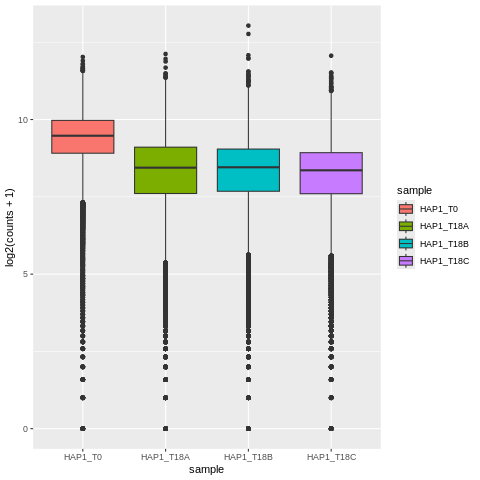

In [ ]:
%%R
# A boxplot presents the dataset in a concise way, highlighting: the mean counts per guide in each sample;
# the IQR for the guide counts in each sample (represented by each boxes limits)
# and any guides with extremely high or low counts are flagged as dots.
ggplot(guide_counts, aes(x = sample, y=log2(counts+1))) +
geom_boxplot(aes(fill = sample))

We can plot the distribution of counts for the different guides in the screen using a density plot. This plot should tell a similar story but some of you might might find it more intuitive.

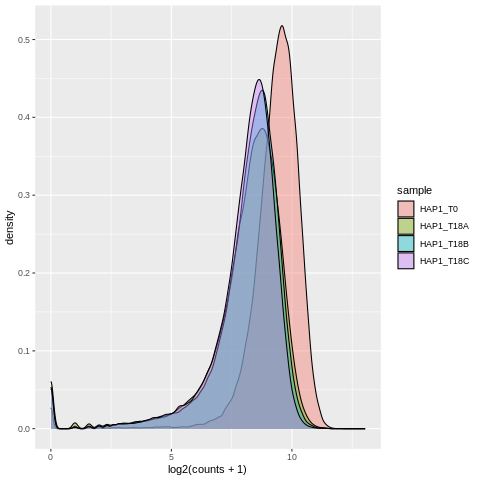

In [ ]:
%%R

ggplot(guide_counts, aes(x=log2(counts+1))) +
geom_density(aes(fill = sample), alpha = 0.4)

### Questions
- Notice that we have chosen to represent the counts for the guide RNAs on a log2 + 1 scale, why do you think might be?
- What do you estimate is the mean number of counts per guide RNA in our samples?
- Most protocols suggest a mean counts-per-guide of at least 200 should be sufficient for conducting a CRISPR knockout screen. Do these samples meet that critera?
- How could you identify any poor-quality or outlier samples in a dataset like this? Are you aware of any techniques for this?

- If a library of 100,000 gRNAs and wanted a minimum starting counts of 500 per guide, how many cells would you have to transduce?

---



------
 <a name="step3"></a>
## Step 3: Identifying significantly perturbed genes in the screen

**MAGECK**

Since our data looks of suitable quality for downstream processing, we will now try to find out which genes in the HAP1 cell-line depends on by comparing over the course of the experiemnt.

To do this we will use [MAGECK](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0554-4): a popular tool for CRISPR counts analysis that uses a negative binomial (NB) model to identify significantly perturbed genes in a datest.

In brief, MAGECK will:
- Median normalise the dataset (*to account for differnces in sequencing depth between samples*)
- Model the mean-variance trend in the dataset (*to better handle guides with very low or very high mean counts*)
- Perform statistical testing and appropriate corrections (*to identify guides with significantly different counts at the start and end of the screen*).

**Figure 4: Data procesing in MAGECK**

![Figure 4: MAGECK processing](https://github.com/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/figures/MAGECK_processing.png?raw=1)


This will give us Log Fold changes (a measure of our effect size - how much guide counts change by) and p-values (a measure of our stastical confidence in the change) for individual **guides** in the dataset.


**Setting up MAGECK**

We can start by installing MAGECK through conda. This would normally print a long message about the installation process in the cell below so to keep things readable we will silence the next cell by redirecting it's output to a "black-hole" in the computer with `&> /dev/null`





In [ ]:
!conda install bioconda::mageck &> /dev/null

Channels:
 - conda-forge
 - bioconda
Platform: linux-64
Solving environment: \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.7.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bioconda::mageck


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    asttokens-2.4.1            |     pyhd8ed1ab_0          28 KB  conda-forge
    ca-certificates-2024.8.30  |       hbcca054_0         155 KB  conda-forge
    certifi-2024.8.30          |     pyhd8ed1ab_0         160 KB  conda-forge
    decorator-5.1.1            |     pyhd8ed1ab_0          12 KB  conda-forge
    exceptiongroup-1.2.2       |     pyhd8ed1ab_0          20 KB  conda-forge
    executing-2.1.0            |     pyhd8ed1ab_0          28 KB  cond

**Verifying the installation has worked**

Once the above cell has finished executing you should be able to check that MAGECK is installed and look at the tool's options using a `-h` flag.


In [ ]:
!mageck -h

usage: mageck test [-h] -k COUNT_TABLE (-t TREATMENT_ID | --day0-label DAY0_LABEL) [-c CONTROL_ID]
                   [--paired] [--norm-method {none,median,total,control}]
                   [--gene-test-fdr-threshold GENE_TEST_FDR_THRESHOLD]
                   [--adjust-method {fdr,holm,pounds}]
                   [--variance-estimation-samples VARIANCE_ESTIMATION_SAMPLES]
                   [--sort-criteria {neg,pos}] [--remove-zero {none,control,treatment,both,any}]
                   [--remove-zero-threshold REMOVE_ZERO_THRESHOLD] [--pdf-report]
                   [--gene-lfc-method {median,alphamedian,mean,alphamean,secondbest}]
                   [-n OUTPUT_PREFIX]
                   [--control-sgrna CONTROL_SGRNA | --control-gene CONTROL_GENE]
                   [--normcounts-to-file] [--skip-gene SKIP_GENE] [--keep-tmp]
                   [--additional-rra-parameters ADDITIONAL_RRA_PARAMETERS] [--cnv-norm CNV_NORM]
                   [--cell-line CELL_LINE] [--cnv-est CNV_EST]


**How to use MAGECK**
Try accessing the help messages for the two mageck subcommands `magek count -h` and `magek test -h` by filling the code blocks below - How do they work?

In [ ]:
# Try to access the count help message here

In [ ]:
# Try to access the stat help message here

**Running MAGECK**

Now that MAGECK is installed and ready to run we will need to define the *contrast* we want to perform (comparing between our T0 and our T18 samples). Within the MAGECK command options we can do this by define our control (`c=T0`) and treatment samples (`t=T18A,T18B,T18C`) based on their column position in the file (starting from 0).

We will also instruct MAGECK to name the outputs `all_vs_control` and to output the "normalised" guide counts it generates to a file with `--normcounts-to-file`

In [ ]:
!mageck test -k reads_hap1.txt -c 0 -t 1,2,3 -n all_vs_control --normcounts-to-file


INFO  @ Mon, 16 Sep 2024 16:37:07: Parameters: /usr/local/bin/mageck test -k reads_hap1.txt -c 0 -t 1,2,3 -n all_vs_control --normcounts-to-file 
INFO  @ Mon, 16 Sep 2024 16:37:07: Welcome to MAGeCK v0.5.9.5. Command: test 
INFO  @ Mon, 16 Sep 2024 16:37:07: Loading count table from reads_hap1.txt  
INFO  @ Mon, 16 Sep 2024 16:37:07: Processing 1 lines.. 
INFO  @ Mon, 16 Sep 2024 16:37:07: Loaded 71090 records. 
INFO  @ Mon, 16 Sep 2024 16:37:07: Loading Rnw template file: /usr/local/lib/python3.10/site-packages/mageck/test_report.Rmd. 
INFO  @ Mon, 16 Sep 2024 16:37:07: Loading R template file: /usr/local/lib/python3.10/site-packages/mageck/plot_template.RTemplate. 
INFO  @ Mon, 16 Sep 2024 16:37:07: Loading R template file: /usr/local/lib/python3.10/site-packages/mageck/plot_template_indvgene.RTemplate. 
INFO  @ Mon, 16 Sep 2024 16:37:07: Loading Rnw template file: /usr/local/lib/python3.10/site-packages/mageck/plot_template.Rnw. 
INFO  @ Mon, 16 Sep 2024 16:37:07: Treatment samples:

**Results**

As this block of code executes, it will progressively generate several files when the steps of the MAGECK process complete. One of the first will be a `.normalized.txt` file that contains revised guide counts after median normalisation. Median normalisation should help control for differences in the total amount of sequencing reads between samples.

Let's visualise this file in R:

In [ ]:
%%R
normalised_counts <- read_tsv("/content/all_vs_control.normalized.txt") |>
                     pivot_longer(cols = contains("HAP1"),
                                  values_to = "counts",
                                  names_to = "sample")

ggplot(normalised_counts, aes(x = sample, y=log2(counts+1))) +
geom_boxplot(aes(fill = sample))



R[write to console]: Error in pivot_longer(read_tsv("/content/all_vs_control.normalized.txt"),  : 
  could not find function "pivot_longer"




Error in pivot_longer(read_tsv("/content/all_vs_control.normalized.txt"),  : 
  could not find function "pivot_longer"



---
### Questions
- If you look back at the boxplots of the raw guide counts, how has normalisation by MAGECK affected the dataset?
---

**Summary files**

The next two outputs from the tool that are worth inspecting are the guide-level and gene-level summaries.

**Guide-level summary**

The guide-level summary tell us the degree to which guide RNAs were depleted or enriched during the screen. We could look at the most depleted guides from the library like so:

In [ ]:
%%R
read_tsv("/content/all_vs_control.sgrna_summary.txt") |>
filter(LFC < 0) |>
select(sgrna, Gene, control_mean, treat_mean, LFC, FDR) |>
arrange(FDR)

UsageError: Cell magic `%%R` not found.


Remember - here, LFC (logFoldChange) represents the magnitude of the depletion (effective size) and FDR represents our level of statistical confidence that the depletion is not due to random chance (adjusted P-value subject to Benjami-Hochberg False discovery rate correction).

**Gene-level summary**

The gene-level summary file tells us which genes are the most strongly perturbed in the screen:

In [ ]:
%%R
read_tsv("/content/all_vs_control.gene_summary.txt")

Rows: 18056 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): id
dbl (13): num, neg|score, neg|p-value, neg|fdr, neg|rank, neg|goodsgrna, neg...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 18,056 × 14
   id        num  `neg|score` `neg|p-value` `neg|fdr` `neg|rank` `neg|goodsgrna`
   <chr>   <dbl>        <dbl>         <dbl>     <dbl>      <dbl>           <dbl>
 1 POLR2L      4      3.85e-9   0.000000274   0.00103          1               4
 2 EIF3A       4      2.08e-8   0.000000274   0.00103          2               4
 3 GTPBP10     4      7.41e-8   0.000000274   0.00103          3               4
 4 PES1        4      9.76e-8   0.000000274   0.00103          4               4
 5 MRPL53      4      1.35e-7   0.000000823   0.00103          5               4
 6 TCEB2       4      1.36e-7   0.000000

These gene level statistics are generated in MAGECK by combining the results that were obtained when mutliple guides in the library targeted a gene. This way genes where multiple guides have large peturbations will have larger summary scores.



If we were to pick out a particular gene - e.g. *PRPF38B* and look at it's counts in different samples we should see a similar picture


In [5]:
%%R

normalised_counts <- read_tsv("/content/all_vs_control.normalized.txt") |>
                     pivot_longer(cols = contains("HAP1"),
                                  values_to = "counts",
                                  names_to = "sample")
genewise_counts <- normalised_counts |>
filter(Gene == "PRPF38B") |>
mutate(screen_stage = case_when(sample == "HAP1_T0" ~ "before",
                                TRUE ~ "post_screen"))
genewise_counts

ggplot(genewise_counts, aes(x= sgRNA, y = log2(counts + 1))) +
geom_boxplot(aes(fill = screen_stage)) +
geom_jitter(data = genewise_counts, aes(x = sgRNA, y = log2(counts+1), color = screen_stage),
            position = position_jitterdodge(jitter.width = 0.2, dodge.width = 0.7)) +
theme(axis.text.x = element_text(angle = 90, hjust = 1))


R[write to console]: Error in pivot_longer(read_tsv("/content/all_vs_control.normalized.txt"),  : 
  could not find function "pivot_longer"




Error in pivot_longer(read_tsv("/content/all_vs_control.normalized.txt"),  : 
  could not find function "pivot_longer"


**How summarising across guides works**

Summarising across genes is achieved in MAGECK by a technique called Robust Rank Aggregation (RRA). RRA organises CRISPR guides in a list according to the *p-value* for their depletion/enrichment. In the figure below this would mean the most significantly depleted guides are placed at the left hand side of the list.The algorithm then looks for genes whose guides are not evenly distributed throughout the list (*e.g.* a gene who's guides are all depleted or are all strongly enriched)

**Figure 5: Robust Rank Aggregation**

![Figure 5: Robust Rank Aggregation](https://github.com/WCSCourses/CRISPR_Informatics_2024/blob/jb63_screening_module/modules/crispr_screen_analysis/figures/robust_rank_aggregation.png?raw=1)

----
### Questions
- Take a look at the top gene's reported in the cell above and perform a quick internet search for them in another tab. Does their behaviour in the screen match up with what you might expect?

----


<a name="step4"></a>
## Step 4: Validating the results of our screen  

All of this looks good so far, but how can we be sure that our screen worked the way it should?


In other experimental methods you would probably want to use a positive and negative control to check that everything behaved as you might expect. It turns out we can do the same in a CRISPR screen by including in-built controls within the library.
- For a **negative control** we can look at the behaviour of guides that target known **Non-essential genes** (NEGS)
- For a **postive control** we can look at the behaviour of guides targeting known **Common essential genes** (CEGS) that in previous experiments have been shown to cause cell death when targeted.

So let's read in some files that contain these genes and label the genes in our CRISPR dataset according to their expected behaviour.

In [ ]:
  %%R
non_essential <- read_tsv("/content/NEGv1.txt") |>
select(GENE) |>
mutate(type = "non-essential")

essential <- read_tsv("/content/CEGv2.txt") |>
select(GENE) |>
mutate(type = "common-essential")


essentiality_class <- bind_rows(non_essential, essential)
essentiality_class


Rows: 927 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): GENE, HGNC_ID
dbl (1): ENTREZ_ID

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 684 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): GENE, HGNC_ID
dbl (1): ENTREZ_ID

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 1,611 × 2
   GENE   type         
   <chr>  <chr>        
 1 ABCG8  non-essential
 2 ACCSL  non-essential
 3 ACTL7A non-essential
 4 ACTL7B non-essential
 5 ACTL9  non-essential
 6 ACTRT1 non-essential
 7 ADAD1  non-essential
 8 ADAM18 non-essential
 9 ADAM2  non-essential
10 ADAM20 non-essential
# ℹ 1,601 more rows
# ℹ Use `print(n = ...)` to see more row

This gives us an object in R that describes which genes are essential and which are non-essential.Now, let's add this information to our gene-level dataset to see what kind of genes are amongst our top most depleted genes.

We can link up the two pieces of data using an operation called a join - where rows with matching "keys" get merged


In [ ]:
%%R
gene_summary_data <- read_tsv("/content/all_vs_control.gene_summary.txt")

annotated_data <- left_join(gene_summary_data, essentiality_class, by = c("id" = "GENE"))

annotated_data |>
select(id, type, `neg|score`, `neg|fdr`)

Rows: 18056 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): id
dbl (13): num, neg|score, neg|p-value, neg|fdr, neg|rank, neg|goodsgrna, neg...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 18,057 × 4
   id      type               `neg|score` `neg|fdr`
   <chr>   <chr>                    <dbl>     <dbl>
 1 POLR2L  common-essential 0.00000000385   0.00103
 2 EIF3A   common-essential 0.0000000208    0.00103
 3 GTPBP10 <NA>             0.0000000741    0.00103
 4 PES1    <NA>             0.0000000976    0.00103
 5 MRPL53  common-essential 0.000000135     0.00103
 6 TCEB2   <NA>             0.000000136     0.00103
 7 MTG2    common-essential 0.000000164     0.00103
 8 CHORDC1 <NA>             0.000000175     0.00103
 9 RPSA    <NA>             0.000000183     0.00103
10 POLR3H  common-essential 0.000000


Does this line up with what you'd expect?


### A more quantitative approach

We can actually quantify the the success of a screen by checking the degree to which common essential genes relative to non-essential genes. At WTSI we frequently use a summary stastistic called the Null Normalised Mean Difference (NNMD) for this purpose. Essentially a more negative NNMD for a CRISPR screen indicates a larger seperation in behaviour between core essential and non-essential genes.

It is calculated as:

$$
\text{NNMD} = \frac{\text{Mean(LFC_CEGs)} -\text{Mean(LFC_NEGs)}}{\text{Std-dev(LFC_NEGs)}}
$$


So, when we calculate the NNMD of this screen by runninng the code block we get a value of....



In [ ]:
%%R
  # Calculate nnmd
  nnmd <- annotated_data |>
    dplyr::rename(LFC = `neg|lfc`) |>
    group_by(type) |>
    summarise(mean_lfc = mean(LFC), sd_lfc = sd(LFC)) |>
    pivot_wider(names_from = type,
                values_from = c(mean_lfc, sd_lfc)) |>
    mutate(nnmd = (`mean_lfc_common-essential` - `mean_lfc_non-essential`) /
                 `sd_lfc_non-essential`) |>
    mutate(nnmd_label = sprintf('NNMD = %.2f', nnmd))
  nnmd |> select(nnmd)

# A tibble: 1 × 1
   nnmd
  <dbl>
1 -7.46


**Results and reflections**

The Cancer dependency map requires an NNMD value of -1.0 or less to consider a screen suitable for further analysis, so the results of this screen look encouraging.

We can visualise what the NNMD score for the screen represents by plotting the distribution of guide changes in our screen for our negative and positive control genes. In this plot the NA genes are those where the essentiality is not known.

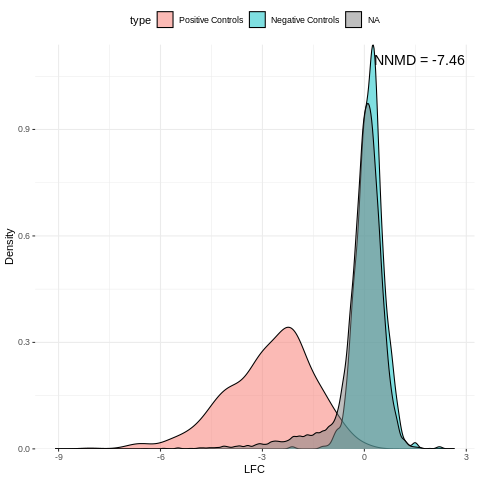

In [ ]:

%%R
ggplot(annotated_data, aes(x = `neg|lfc`, fill = type)) +
          geom_density(alpha = 0.5) +
          labs(x = "LFC", y = "Density") +
          theme_bw() +
          theme(legend.position = "top", panel.border = element_blank()) +
          scale_fill_discrete(
            labels = c("Positive Controls", "Negative Controls")
          ) +
          scale_y_continuous(expand = c(0, 0)) +
          annotate(
            "text", x = Inf, y = Inf, label = nnmd[["nnmd_label"]],
            hjust = 1.1, vjust = 2, size = 5, colour = "black"
          )

----
### Questions
- Looking at the distribution above, what can you say about the essentiality of the genes with unknown essentiality (NA) in this HAP1 cell line?
- Imagine you were working in a non-model organism and didn't have a list of non-essential genes to use as a negative control. What guides could you use instead?
- Similarly, can you think of an alternative set of guides that you might be able to use as a positive control?

----

Since we now have some confidence that the screen was a success, let's visualise it's results with a volcano plot. Volcano plots can be a helpful final stage visualisation for this kind of data because they include both effect sizes (LogFoldChanges) and stastical confidence measures (p-values).

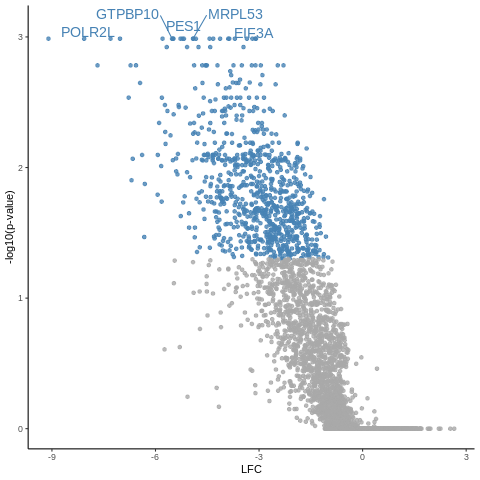

In [ ]:

%%R
library(ggrepel)
gene_summary <- annotated_data |>
        mutate(Significant = ifelse(`neg|fdr` < 0.05, "Yes", "No"))

gene_summary_labels <- gene_summary |>
    filter(`neg|fdr` < 0.05) |>
    head(5)

ggplot(gene_summary, aes(x = `neg|lfc`, y = -log10(`neg|fdr`),
                                 label = id, color = Significant)) +
                geom_point(alpha = 0.8) +
                geom_text_repel(data = gene_summary_labels, aes(label = id),
                        size = 5, nudge_y = 0.1,
                        force = 10, max.overlaps = Inf) +
                scale_color_manual(values = c("darkgrey", "steelblue")) +
                theme_bw() +
                theme(legend.position = "none",
                        panel.grid.major = element_blank(),
                        panel.grid.minor = element_blank(),
                        panel.border = element_blank(),
                        axis.line = element_line(color = "black"),
                        axis.line.x.top = element_blank(),
                        axis.line.y.right = element_blank()) +
                labs(x = "LFC", y = "-log10(p-value)")


---
Question;

If you have ever created a volcano plot for other kinds of bioinformatics analysis such as transcriptomics this volcanoplot might look quite unfamiliar. How does a CRISPR knockout volcano plot differ from others you've seen? Does it make sense why?

---

## <a name="step5"></a>
## Step 5: Other tools for CRISPR screen analysis and post-processing considerations

MAGECK is not the only game in town - there are several other tools that can be applied to the task we have just performed (and accompanying papers about why each of them gives the best results of the lot!).

**gscreend**

One example of the more recently published CRISPR analysis tool is `gscreend`, an R package that performs the same kind of screen analysis as MAGECK but which accounts for bottlenecking: a phenomenon that occurs when cells are passaged in a screen and random selection reduces the diverity of the cell population.

We can run gscreend by on our dataset by installing a couple of R packages. This will take a little while, so execute the next code block and take a quick break whilst it runs.



In [3]:
%%R
install.packages("BiocManager")
BiocManager::install("gscreend")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/BiocManager_1.30.25.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 593414 bytes (579 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


Update all/some/none? [a/s/n]: n


**Next step**

Once the new R libraries we need for gscreend are installed, we will load them into our notebook session with:

In [9]:
%%R
library(tidyverse)
library(gscreend)
library(SummarizedExperiment)



R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘matrixStats’


R[write to console]: The following object is masked from ‘package:dplyr’:

    count


R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
  

To run gscreend on the dataset we will need to reformat the data slightly, encoding the counts data within a "counts matrix" and then inputting our counts and sample metadata into a SummarizedExperiment data container.

In [22]:
%%R
input_file <- read_tsv("reads_hap1.txt")

rowData <- data.frame(sgRNA_id = input_file$SEQUENCE,
                    gene = input_file$GENE)

colData <- data.frame(samplename = c("library", "RA", "RB", "RC"),
                    timepoint = c("T0", "T1", "T1", "T1"))


counts_matrix <- data.frame(input_file |> select(contains("HAP1"))) |>
                as.matrix() |>
                unname()


se <- SummarizedExperiment(assays=list(counts=counts_matrix),
                    rowData=rowData, colData=colData)

With the data now formatted correctly we can i) inform R that our experiment is a pooled CRISPR screen and ii) trigger the analysis process. Gscreend will perform several similar steps to MAGECK: normalising the data, calculating Log Fold Changes and aggregrating the results of guide RNAs to generate genes. This will take several minutes - so sit tight!

In [23]:
%%R
pse <- createPoolScreenExp(se)
pse_an <- RunGscreend(pse)

R[write to console]: Creating PoolScreenExp object from a SummarizedExperiment object.

R[write to console]: References and samples are named correctly.

R[write to console]: Data concerning sgRNA and genes is provided.

R[write to console]: Size normalized count data.

R[write to console]: Calculated LFC.

R[write to console]: Fitted null distribution.

R[write to console]: Calculated p-values at gRNA level.

R[write to console]: Ranking genes...

R[write to console]: ... for positive fold changes

R[write to console]: ... for negative fold changes

R[write to console]: gscreend analysis has been completed.



**Analysing the results**

Gscreend will store the results of the analysis in a ResultsTable object. We can access these with the `ResultsTable` function and find out the most strongly depleted genes in the dataset like so:

In [29]:
%%R
res <- ResultsTable(pse_an, direction = "negative")
write_tsv(res, "gscreend_depleted_genes.tsv")

res |>
as_tibble() |>
arrange(lfc)



# A tibble: 18,056 × 4
   Name        fdr     pval   lfc
   <chr>     <dbl>    <dbl> <dbl>
 1 POLR2L  0       0        -7.29
 2 POLR3H  0       0        -7.14
 3 TCEB2   0       0        -7.01
 4 ELP5    0       0        -6.87
 5 GPN3    0       0        -6.67
 6 RPS11   0       0        -6.19
 7 ISG20L2 0       0        -6.13
 8 RPL30   0       0        -6.06
 9 RRM1    0       0        -6.05
10 RPL34   0.00198 0.000152 -6.04
# ℹ 18,046 more rows
# ℹ Use `print(n = ...)` to see more rows


---
Question:
- How do the top genes found with gscreend compare to those found with MAGECK?
- For those familiar with R, feel free to try generating a volcano plot for this dataset!
- As an additional extension, you might want to try plotting a comparison of the log fold change values obtained for the two methods. What do you notice?
_--

## Other analysis tools

It would be remiss if I didn't mention [BAGEL2](https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-020-00809-3) here. BAGEL2 calculates "Bayes Factors" to represent gene essentiality. It builds a classifier using NEG and CEG behaviours and assigns genes with unknown essentiality to one of these classes with a probability estiamte. In some scenarios BAGEL has better sensitivity to detect essential genes and it's latest version can better accounts for the off-target effects of guide RNAs on cell survival. A detailed exploration of BAGEL was ommitted here largely because it's installation is more tempermental than the other methods.

Each of these methods will have different sensitivities and specificities (abilities to distinguish true-positives and true-negatives from false-positives and false-negatives) but they should give broadly the same results. You might want to compare and contrast tools or take a consensus from several of them.


## Considerations

**What to use as a reference sample?**

In this experiment, we used a "T0" pre-screen sample derived from a transduced cell population for our comparisons. There have been suggestions that a sample of the plasmid library to be used in the transfection might be superior reference. It has been observed that gRNAs targeting essential genes already have their abundance reduced at T0 - so some of the essential gene depletions in our screen might be underestimates!


**Bottlenecking**

The act of splitting an discarding cells is a bottlenecking event, which will reduce diversity in the cell population. This can artificially increase the depletion of rare guides from your experiment and lead to them being called as essential. Using gscreend as an analysis tool might help mitigate this.



**Copy-number effects**

In our analysis we've treated our genes with the implicit assumption that there are equal copies of each gene in the genome. In cancer cells though, genomic instability and copy number alterations are widespread and this assumption might not hold true.

Several studies have demonstrated that targeting Cas9 to regions where there are copy number gains will cause multiple DNA double-strand breaks and induce a larger gene-independent DNA-damage response. This causes the cells to enter cell-cycle arrest and the net effect of this is that regions with copy number amplifications are much more likely to deplete and appear as essential in CRISPR knockout screens.

Several tools have been built to mitigate this effect. MAGECK, for instance has an inbuilt copy-number adjustment tool that controls for CNA's. Alternatively, [CRISPRcleanR](https://www.sanger.ac.uk/tool/crisprcleanr/) applies circular binary segmentation algorithm to identify genomic regions where sgRNA impact is correlated. This algorithm works on the basis that contigous genes should not be equally essential and attributes situations where this phenomenon is observed to being a copy number alteration.

## <a name="summary"></a>
## Summary <a name="Summary"></a>


- Given a CRISPR counts matrix, you can use data wrangling tools like R or python to quickly check that sequencing samples meet your expectations.
- You can use tools such as MAGECK, BAGEL2 and gscreend to identify depleted or enriched guides in an experiment.
- These tools perform contrasts that compare guide RNA abundances in treatment vs. control samples and then aggregate this data at the gene level
- By including positive and negative control genes in your guide RNA library, you can use metrics like NNMD to validate that a screen was successful.
- Experimental and genomic factors might confound your experiment - so try to bear these in mind.


🎉🎉That's it for today! 🎉🎉


In many ways we've only just started and there's lots more to explore: You might want to look at topics like pre-filtering low-count guides out of our dataset, identifying problematic samples using tools like PCA, and perfoming multi-factorial analysis with tools like MAGECK-MLE. You might just want to find a friendly bioinformatician to lend a hand. Either way - happy screening!



## <a name="references"></a>
## References
- Andersson, B. S., Beran, M., Pathak, S., Goodacre, A., Barlogie, B., & McCredie, K. B. (1987). Ph-positive chronic myeloid leukemia with near-haploid conversion in vivo and establishment of a continuously growing cell line with similar cytogenetic pattern. Cancer genetics and cytogenetics, 24(2), 335–343. https://doi.org/10.1016/0165-4608(87)90116-6

- [Integrated cross-study datasets of genetic dependencies in cancer](https://www.nature.com/articles/s41467-021-21898-7)

- [Extracting Biological Insights from the Project Achilles Genome-Scale CRISPR Screens in Cancer Cell Lines](https://www.biorxiv.org/content/10.1101/720243v1)

- Aguirre A.J., Meyers R.M., Weir B.A., et al. Genomic copy number dictates a gene-independent cell response to CRISPR-Cas9 targeting. Cancer Discov June 3 2016 DOI: 10.1158/2159-8290.CD-16-0154

- BAGEL: a computational framework for identifying essential genes from pooled library screens. Traver Hart and Jason Moffat. BMC Bioinformatics, 2016 vol. 17 p. 164.

- [Pooled Lentiviral CRISPR-Cas9 Screens for Functional Genomics in Mammalian Cells](https://link.springer.com/protocol/10.1007/978-1-4939-8805-1_15)

- [Genome-scale CRISPR-Cas9 knockout and transcriptional activation screening
](https://www.nature.com/articles/nprot.2017.016)